Testing of the continuous wavelet transform for potential use as features in the model

In [ ]:
!pip install -q PyWavelets torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/INL')

Mounted at /content/drive


In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import random
from torch_geometric.loader import DataLoader

In [ ]:
y = np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/label2.npy')
X_train =  np.load('/content/drive/MyDrive/Colab Notebooks/INL/processed_data/X_train2.npy')

In [ ]:
X_train.shape

(11730, 31, 1770)

In [ ]:
fs = 590 #Sampling frequency
n_ecogs = 31 #number of ecog channels
window_duration = 3 #seconds

X_train = X_train.reshape(-1, n_ecogs * window_duration, fs)

dataset = []

for idx in tqdm(range(X_train.shape[0])):
    eeg_clip = X_train[idx,:,:]
    label = y[idx]
    if label == 7: #ignore label 7, which produces weird results
        continue
    dataset.append((torch.tensor(eeg_clip).float(), torch.tensor((label), dtype=torch.long)))

random.shuffle(dataset)

100%|██████████| 11730/11730 [00:07<00:00, 1553.10it/s]


In [ ]:
train_dataloader = DataLoader(dataset , batch_size = 64  )

In [ ]:
wavelet = 'morl'
scales = np.arange(1, 129)

In [ ]:
batch_size = 64
n_channels = 31
n_samples = 590  # Window length
x, labels = next(iter(train_dataloader))

In [ ]:
x.shape

torch.Size([64, 93, 590])

In [ ]:
wavelet_features = []
for batch in x:
    batch_features = []
    for channel in batch:
        coefs, _ = pywt.cwt(channel.numpy(), scales, wavelet)

        batch_features.append(torch.tensor(coefs, dtype=torch.float32))  # (n_scales, n_samples)
    wavelet_features.append(torch.stack(batch_features))  # (n_channels, n_scales, n_samples)

wavelet_features = torch.stack(wavelet_features) # (batch_size, n_channels, n_scales, n_samples)

In [ ]:
wavelet_features[42][28].shape

torch.Size([128, 590])

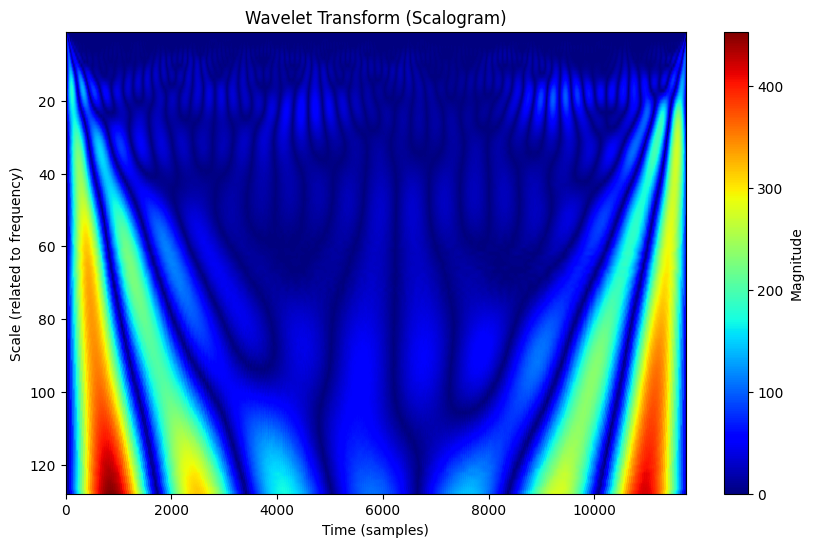

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(wavelet_features[42][28]), aspect='auto', cmap='jet', extent=[0, len(y), scales[-1], scales[0]])
plt.colorbar(label='Magnitude')
plt.xlabel('Time (samples)')
plt.ylabel('Scale (related to frequency)')
plt.title('Wavelet Transform (Scalogram)')
plt.show()